# Analog bit project walkthrough

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.run_functions_eagerly(True)
try:
    from tueplots import bundles
    plt.rcParams.update(bundles.neurips2022())
except ModuleNotFoundError:
    pass
%load_ext autoreload
%autoreload 2

2023-05-15 15:12:11.809183: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## How to generate the data

Several ways to create data, only one generator is implemented, the ```flags``` dataset

In [2]:
# imports
from utils.data_gen import get_data_gen

In [3]:
generate_train_data = get_data_gen('flags', (3,8), 100, rgb=True)
generate_test_data = get_data_gen('flags', (3,8), 20, rgb=True)

In [4]:
train_data = generate_train_data()
test_data = generate_test_data()

In [5]:
train_data.shape

(100, 3, 8, 3)

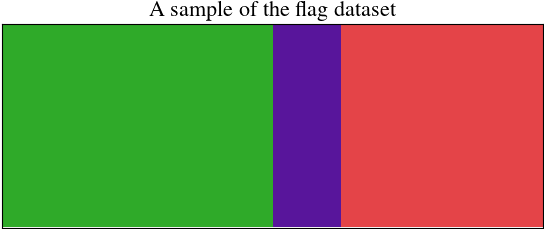

In [6]:
from utils.display import show_flag
show_flag(train_data[2])

## Fake predictor task

To test our model, we will create a false ground truth

In [7]:
# Fake ground truth
def invert_color(data : np.ndarray):
    """Invert the color of RGB channels"""
    return 255 - data
train_ground_truth = invert_color(train_data)
test_ground_truth = invert_color(test_data)

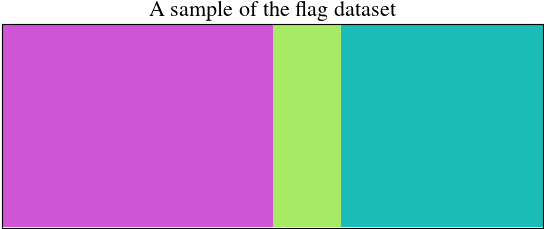

In [8]:
show_flag(train_ground_truth[2])

## Convert to bits

In [9]:
from utils.bit_encoding import rgb2bit, get_x_channels

b_type = 'uint8'
channels = get_x_channels(b_type)
kwargs = {'b_type': b_type, 'b_scale': 1.0, 'x_channels': channels}
train_data_bits = rgb2bit(images=train_data, **kwargs)
gt_train_data_bits = rgb2bit(images=train_ground_truth, **kwargs)
test_data_bits = rgb2bit(images=test_data, **kwargs)
gt_test_data_bits = rgb2bit(images=test_ground_truth, **kwargs)

2023-05-15 15:12:15.237103: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
print("(Number of samples, height, width, analogbits) =", train_data_bits.shape)

(Number of samples, height, width, analogbits) = (100, 3, 8, 24)


## Define noise and denoiser step

In [11]:
from models.dummy_model import get_model
input_shape = train_data_bits.shape[1:]
model = get_model(input_shape=input_shape)

In [12]:
model(train_data_bits).shape

TensorShape([100, 3, 8, 24])

In [13]:
train_dataset_bits = tf.data.Dataset.from_tensor_slices(train_data_bits)
gt_train_dataset_bits = tf.data.Dataset.from_tensor_slices(gt_train_data_bits)
test_dataset_bits = tf.data.Dataset.from_tensor_slices(test_data_bits)
gt_test_datasets_bits = tf.data.Dataset.from_tensor_slices(gt_test_data_bits)

In [14]:
loss_fn = tf.keras.losses.MeanAbsoluteError()

In [15]:
features = next(iter(train_dataset_bits.batch(32)))
ground_truth = next(iter(gt_train_dataset_bits.batch(32)))
l = loss_fn(model(features), ground_truth)
print("Loss test: {}".format(l))

Loss test: 1.0013221502304077


2023-05-15 15:12:15.748018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [100,3,8,24]
	 [[{{node Placeholder/_0}}]]
2023-05-15 15:12:15.756131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [100,3,8,24]
	 [[{{node Placeholder/_0}}]]


In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [17]:
training_dataset = tf.data.Dataset.zip((train_dataset_bits, gt_train_dataset_bits))

In [18]:
model.compile(
    optimizer=optimizer,
    loss=loss_fn
)

In [19]:
model.fit(
    x=training_dataset.batch(32),
    epochs=200,
    batch_size=32
)

Epoch 1/200
3/4 [=====================>........] - ETA: 0s - loss: 0.9939

2023-05-15 15:12:15.992690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [100,3,8,24]
	 [[{{node Placeholder/_2}}]]


4/4 [==============================] - 0s 32ms/step - loss: 0.9941
Epoch 2/200
4/4 [==============================] - 0s 31ms/step - loss: 0.9511
Epoch 3/200
4/4 [==============================] - 0s 31ms/step - loss: 0.9191
Epoch 4/200
4/4 [==============================] - 0s 30ms/step - loss: 0.8890
Epoch 5/200
4/4 [==============================] - 0s 30ms/step - loss: 0.8661
Epoch 6/200
4/4 [==============================] - 0s 38ms/step - loss: 0.8458
Epoch 7/200
4/4 [==============================] - 0s 37ms/step - loss: 0.8301
Epoch 8/200
4/4 [==============================] - 0s 31ms/step - loss: 0.8175
Epoch 9/200
4/4 [==============================] - 0s 30ms/step - loss: 0.8054
Epoch 10/200
4/4 [==============================] - 0s 28ms/step - loss: 0.7953
Epoch 11/200
4/4 [==============================] - 0s 28ms/step - loss: 0.7862
Epoch 12/200
4/4 [==============================] - 0s 28ms/step - loss: 0.7791
Epoch 13/200
4/4 [==============================] - 0s 30ms/s

In [20]:
feature_test = model(features, training=False)

In [21]:
from utils.bit_encoding import bit2rgb
feature_test_int = bit2rgb(feature_test, b_type=b_type)
feature_int = bit2rgb(features, b_type=b_type)

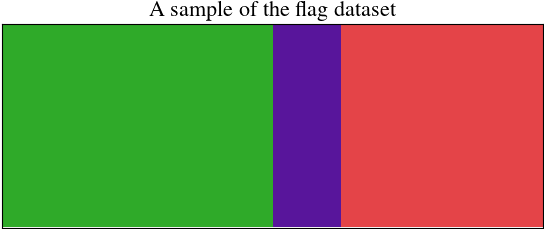

In [22]:
# Original data
show_flag(feature_int[2])

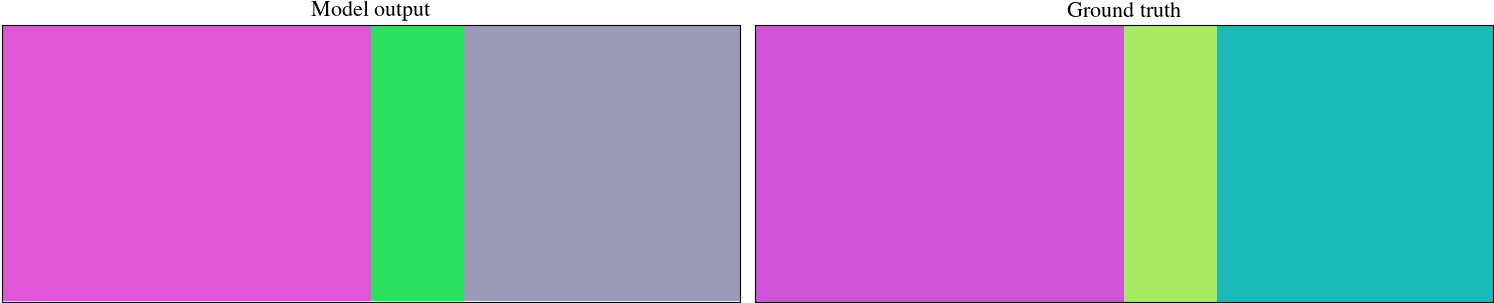

In [23]:
from matplotlib import ticker

fig, axs = plt.subplots(ncols=2, figsize=(15,5))
axs[0].imshow(feature_test_int[2])
axs[0].set_title('Model output', fontsize=16)
axs[0].xaxis.set_major_locator(ticker.NullLocator())
_ = axs[0].yaxis.set_major_locator(ticker.NullLocator())

axs[1].imshow(1.0 - feature_int[2])
axs[1].set_title('Ground truth', fontsize=16)
axs[1].xaxis.set_major_locator(ticker.NullLocator())
_ = axs[1].yaxis.set_major_locator(ticker.NullLocator())

## Now using diffusion

In [24]:
from utils.diffusion_utils import Scheduler
scheduler = Scheduler('cosine')

In [35]:
inputs_noised, noise, time_step, gamma = scheduler.add_noise(train_data_bits)

In [41]:
from models.analog_bits import Model

In [106]:
from argparse import Namespace
from dotwiz import DotWiz

config = {
    'dataset': {
        'image_size' : (3,8),
        'num_classes' : 1,
    },
    'model' : {
        'train_schedule' : 'cosine',
        'x0_clip' : 'auto',
        'b_scale' : 1.0,
        'm_kwargs' : {
            'model_name' : 'unet',
            'input_shape' : (3,8,24)
        },
        'b_type' : 'uint8',
        'self_cond' : 'x',
        'pred_type' : 'eps',
        'conditional' : 'none',
        'normalize_noisy_input' : False,
        'infer_schedule' : 'cosine',
        'td' : 0,
        'guidance' : 0,
    }
}
config = DotWiz(config)

In [107]:
model_new = Model(config)

In [108]:
output = model_new(train_data, train_data)

In [112]:
samples = model_new.sample(
    num_samples=1,
    iterations=10
)

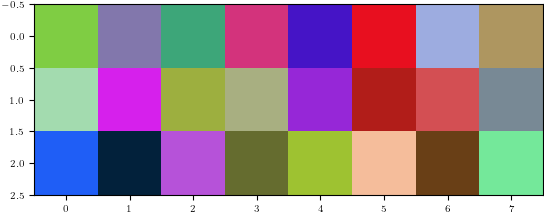

In [114]:
plt.imshow(samples[0])